Sources:

1. https://www.kaggle.com/code/ciobeni/fake-news-prediction (for preprocessing, countvectorizer and evaluation code)
2. https://excellencetechnologies.in/blog/bag-of-words-count-vectorizer/
3. https://www.analyticsvidhya.com/blog/2021/08/a-friendly-guide-to-nlp-bag-of-words-with-python-example/
4. https://www.tensorflow.org/tutorials/text/word2vec
5. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
6. https://stackoverflow.com/questions/47711515/apply-countvectorizer-to-column-with-list-of-words-in-rows-in-python

# Importing relevant libraries

In [1]:
import nltk # Used for preprocessing
import string # Used for preprocessing
import numpy as np # Used for saving
import pandas as pd # Used for dataframe
import matplotlib.pyplot as plt # For plotting the graphs
import seaborn as sns # For the confusion matrix

from nltk.corpus import stopwords # Used for preprocessing
from nltk.stem   import WordNetLemmatizer # Used for preprocessing
from nltk.tokenize import word_tokenize # Used for preprocessing
from sklearn.model_selection import train_test_split # Used for splitting the data

from sklearn.model_selection import GridSearchCV # Used for tuning
from sklearn.metrics import confusion_matrix # Used for confusion matrix
from sklearn.feature_extraction.text import CountVectorizer # Used for CountVectorizer feature extraction 
from sklearn.svm import LinearSVC # Used for SVM modeling
from sklearn.model_selection import cross_validate # Used for cross-validation
from sklearn.metrics import classification_report # Used for model evaluation

import joblib # For saving the model

# Loading the data

In [2]:
# Loading the dataset

df = pd.read_csv('WELFake_Dataset.csv', index_col = 0)
df = df.dropna()

# Preprocessing the data

In [3]:
# Preprocessing

def preprocess_text(text):
    text = ''.join([c for c in text if c not in string.punctuation and c not in string.digits])
    tokens = word_tokenize(text, 'english')
    lowered = [x.lower() for x in tokens] # new
    lemmatiser = WordNetLemmatizer()
    lemmatized = [lemmatiser.lemmatize(word) for word in lowered] # Adjusted
    sw = stopwords.words('english')
    stopped = [word for word in lemmatized if word.lower() not in sw]
    return stopped

In [4]:
# Splitting the data

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [5]:
# Create a list of preprocessed articles

prep_X_train = []
for article_train in X_train[:]:
    prep_X_train.append(preprocess_text(article_train))

prep_X_test = []
for article_test in X_test[:]:
    prep_X_test.append(preprocess_text(article_test))

X_train = prep_X_train
X_test = prep_X_test

# Feature Extraction: CountVectorizer

In [6]:
#X_train = X_train.fillna('')
vectorizer = CountVectorizer(analyzer=lambda x: x)
vectorizer.fit(X_train)

CountVectorizer(analyzer=<function <lambda> at 0x7fdf09ffbf70>)

In [7]:
print("Vocabulary size:", len(vectorizer.get_feature_names_out()))

Vocabulary size: 304405


In [8]:
# Initializing and saving CountVectorizer matrix

matrix = vectorizer.transform(X_train) # Matrix is the CBOW feature extraction for X train

In [9]:
frequencies = sum(matrix).toarray()[0]
ngrams = pd.DataFrame(frequencies, index = vectorizer.get_feature_names_out(), columns = ['frequency'])
ngrams = ngrams.sort_values(by='frequency', ascending = False)
ngrams.iloc[:50]

,frequency
’,296899
“,211201
”,209632
wa,196210
said,185210
trump,165861
ha,141004
state,88670
u,85901
would,84263


# Scoring the model: SVM

In [10]:
svm = LinearSVC()
scores = cross_validate(svm, matrix, y_train, scoring=['f1', 'accuracy'], cv=5, n_jobs=-1) # Scoring the training

In [11]:
pd.DataFrame(scores).describe()

,fit_time,score_time,test_f1,test_accuracy
count,5.000000,5.000000,5.000000,5.000000
mean,30.736272,0.193168,0.956674,0.955564
std,3.862867,0.135739,0.001594,0.001674
min,24.191877,0.087364,0.954909,0.953696
25%,31.191470,0.126535,0.955812,0.954569
50%,31.613391,0.136920,0.956663,0.955701
75%,32.270292,0.187609,0.956803,0.955705
max,34.414328,0.427414,0.959182,0.958151


# Tuning

Source:

1. https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/ # For the hyperparameter code
2. https://dataaspirant.com/svm-kernels/#t-1608054630726 # For different kernel options
3. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html # For possible hyperparameters

In [12]:
svm = LinearSVC()

# defining parameter range
param_grid = {'loss': ('hinge', 'squared_hinge'),
              'C': [0.001, 0.01, 0.1, 1, 10, 100]} 
  
grid = GridSearchCV(svm, param_grid, refit = True, cv = 5, verbose = 3)
  
# fitting the model for grid search
grid.fit(matrix, y_train)

# print best parameter after tuning
print(grid.best_params_)
print("\n")

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ...............C=0.001, loss=hinge;, score=0.956 total time=  13.7s
[CV 2/5] END ...............C=0.001, loss=hinge;, score=0.960 total time=   5.3s
[CV 3/5] END ...............C=0.001, loss=hinge;, score=0.956 total time=   4.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ...............C=0.001, loss=hinge;, score=0.960 total time=   5.7s
[CV 5/5] END ...............C=0.001, loss=hinge;, score=0.959 total time=   5.1s
[CV 1/5] END .......C=0.001, loss=squared_hinge;, score=0.962 total time=  17.4s
[CV 2/5] END .......C=0.001, loss=squared_hinge;, score=0.962 total time=  19.0s
[CV 3/5] END .......C=0.001, loss=squared_hinge;, score=0.960 total time=  17.2s
[CV 4/5] END .......C=0.001, loss=squared_hinge;, score=0.966 total time=  23.1s
[CV 5/5] END .......C=0.001, loss=squared_hinge;, score=0.962 total time=  17.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ................C=0.01, loss=hinge;, score=0.963 total time=   9.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ................C=0.01, loss=hinge;, score=0.964 total time=  11.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ................C=0.01, loss=hinge;, score=0.963 total time=  11.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ................C=0.01, loss=hinge;, score=0.967 total time=  11.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ................C=0.01, loss=hinge;, score=0.963 total time=  10.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ........C=0.01, loss=squared_hinge;, score=0.964 total time=  17.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ........C=0.01, loss=squared_hinge;, score=0.965 total time=  18.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ........C=0.01, loss=squared_hinge;, score=0.964 total time=  19.4s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ........C=0.01, loss=squared_hinge;, score=0.967 total time=  13.8s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ........C=0.01, loss=squared_hinge;, score=0.964 total time=  14.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END .................C=0.1, loss=hinge;, score=0.960 total time=  10.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END .................C=0.1, loss=hinge;, score=0.961 total time=  12.8s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .................C=0.1, loss=hinge;, score=0.958 total time=  12.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END .................C=0.1, loss=hinge;, score=0.962 total time=  10.8s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .................C=0.1, loss=hinge;, score=0.961 total time=  10.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END .........C=0.1, loss=squared_hinge;, score=0.960 total time=  11.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END .........C=0.1, loss=squared_hinge;, score=0.961 total time=  12.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .........C=0.1, loss=squared_hinge;, score=0.960 total time=  16.8s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END .........C=0.1, loss=squared_hinge;, score=0.964 total time=  15.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .........C=0.1, loss=squared_hinge;, score=0.961 total time=  12.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ...................C=1, loss=hinge;, score=0.953 total time=  13.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ...................C=1, loss=hinge;, score=0.956 total time=  14.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ...................C=1, loss=hinge;, score=0.954 total time=  10.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ...................C=1, loss=hinge;, score=0.957 total time=  14.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ...................C=1, loss=hinge;, score=0.955 total time=  11.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ...........C=1, loss=squared_hinge;, score=0.954 total time=  10.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ...........C=1, loss=squared_hinge;, score=0.956 total time=  10.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ...........C=1, loss=squared_hinge;, score=0.955 total time=  29.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ...........C=1, loss=squared_hinge;, score=0.958 total time=  17.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ...........C=1, loss=squared_hinge;, score=0.955 total time=  13.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..................C=10, loss=hinge;, score=0.948 total time=  11.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..................C=10, loss=hinge;, score=0.949 total time=  11.3s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..................C=10, loss=hinge;, score=0.950 total time=  12.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..................C=10, loss=hinge;, score=0.955 total time=  12.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..................C=10, loss=hinge;, score=0.951 total time=  13.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..........C=10, loss=squared_hinge;, score=0.949 total time=  11.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..........C=10, loss=squared_hinge;, score=0.950 total time=  11.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..........C=10, loss=squared_hinge;, score=0.951 total time=  10.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..........C=10, loss=squared_hinge;, score=0.955 total time=  11.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..........C=10, loss=squared_hinge;, score=0.952 total time=  10.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END .................C=100, loss=hinge;, score=0.948 total time=  10.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END .................C=100, loss=hinge;, score=0.949 total time=  10.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .................C=100, loss=hinge;, score=0.950 total time=  11.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END .................C=100, loss=hinge;, score=0.955 total time=  31.8s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .................C=100, loss=hinge;, score=0.951 total time=  15.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END .........C=100, loss=squared_hinge;, score=0.948 total time=  19.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END .........C=100, loss=squared_hinge;, score=0.949 total time=  11.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .........C=100, loss=squared_hinge;, score=0.950 total time=  13.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END .........C=100, loss=squared_hinge;, score=0.955 total time=  12.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .........C=100, loss=squared_hinge;, score=0.951 total time=  16.4s
{'C': 0.01, 'loss': 'squared_hinge'}


LinearSVC(C=0.01)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Training the model

In [13]:
# Train the model using the whole training set
svm = LinearSVC(C = 0.01, loss = 'squared_hinge') # Initializing the model
svm.fit(matrix, y_train) # Training the model with the Y train data and X feature extraction data

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.01)

# Using test data

In [14]:
test_matrix = vectorizer.transform(X_test)
y_pred = svm.predict(test_matrix)

In [15]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.974000,0.961814,0.96771,0.967907,0.967797
recall,0.959858,0.975285,0.96771,0.967571,0.967710
f1-score,0.966877,0.968503,0.96771,0.967690,0.967705
support,7025.000000,7283.000000,0.96771,14308.000000,14308.000000


Text(51.0, 0.5, 'Real Labels')

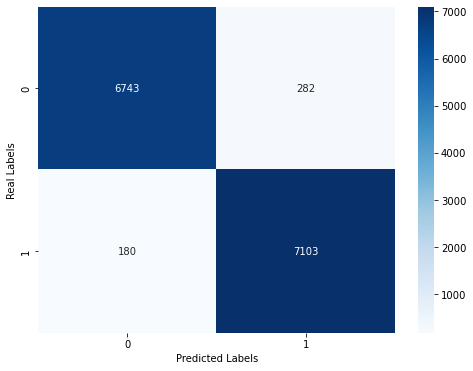

In [16]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

In [17]:
joblib.dump(svm,'/Users/pietervanbrakel/Thesis/LSVM_text.pkl',compress=3)

['/Users/pietervanbrakel/Thesis/LSVM_text.pkl']

In [18]:
svm = joblib.load('/Users/pietervanbrakel/Thesis/LSVM_text.pkl')

# Split confusion matrix

In [19]:
df = pd.read_csv('WELFake_Dataset.csv', index_col = 0)

In [20]:
df_kaggle = df.loc[:20799]
df_McIntire = df.loc[20800:27134]
df_Reuters = df.loc[27135:72032]
df_Buzzfeed = df.loc[72033:]

df_kaggle = df_kaggle.dropna()
df_McIntire = df_McIntire.dropna()
df_Reuters = df_Reuters.dropna()
df_Buzzfeed = df_Buzzfeed.dropna()

In [21]:
print("Nr. of news articles in Kaggle :", len(df_kaggle))
print("Nr. of news articles in McIntire :", len(df_McIntire))
print("Nr. of news articles in Reuters :", len(df_Reuters))
print("Nr. of news articles in Buzzfeed :", len(df_Buzzfeed))

Nr. of news articles in Kaggle : 20664
Nr. of news articles in McIntire : 6285
Nr. of news articles in Reuters : 44487
Nr. of news articles in Buzzfeed : 101


In [22]:
df_kaggle_y = df_kaggle.iloc[:, 2]
df_kaggle_x = df_kaggle.iloc[:, 1]
df_McIntire_y = df_McIntire.iloc[:, 2]
df_McIntire_x = df_McIntire.iloc[:, 1]
df_Reuters_y = df_Reuters.iloc[:, 2]
df_Reuters_x = df_Reuters.iloc[:, 1]
df_Buzzfeed_y = df_Buzzfeed.iloc[:, 2]
df_Buzzfeed_x = df_Buzzfeed.iloc[:, 1]

### Kaggle sub-dataset

In [23]:
# Create a list of preprocessed articles
kaggle_X = []
for article_train in df_kaggle_x[:]:
    kaggle_X.append(preprocess_text(article_train))

df_kaggle_x = kaggle_X

In [24]:
# Create y_pred_Kaggle
kaggle_test_matrix = vectorizer.transform(df_kaggle_x)
kaggle_y_pred = svm.predict(kaggle_test_matrix)

In [39]:
pd.DataFrame(classification_report(df_kaggle_y, kaggle_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.994045,0.986799,0.990273,0.990422,0.990302
recall,0.985786,0.994473,0.990273,0.990129,0.990273
f1-score,0.989898,0.990621,0.990273,0.990260,0.990271
support,9990.000000,10674.000000,0.990273,20664.000000,20664.000000


Text(51.0, 0.5, 'Real Labels')

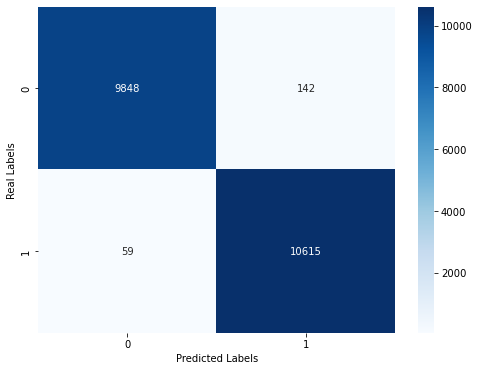

In [26]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(df_kaggle_y, kaggle_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

### McIntire

In [27]:
# Create a list of preprocessed articles
McIntire_X = []
for article_train in df_McIntire_x[:]:
    McIntire_X.append(preprocess_text(article_train))

df_McIntire_x = McIntire_X

In [28]:
# Create y_pred_McIntire
McIntire_test_matrix = vectorizer.transform(df_McIntire_x)
McIntire_y_pred = svm.predict(McIntire_test_matrix)

In [40]:
pd.DataFrame(classification_report(df_McIntire_y, McIntire_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.994412,0.989824,0.992045,0.992118,0.992056
recall,0.989209,0.994732,0.992045,0.991970,0.992045
f1-score,0.991803,0.992272,0.992045,0.992038,0.992044
support,3058.000000,3227.000000,0.992045,6285.000000,6285.000000


Text(51.0, 0.5, 'Real Labels')

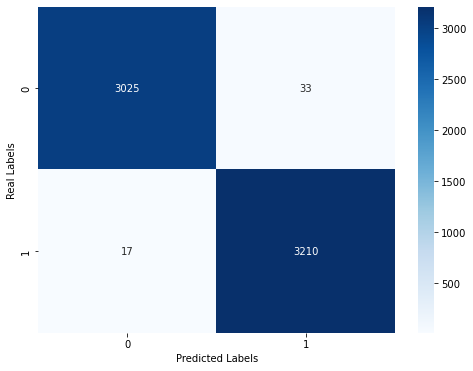

In [30]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(df_McIntire_y, McIntire_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

### Reuters

In [31]:
# Create a list of preprocessed articles
Reuters_X = []
for article_train in df_Reuters_x[:]:
    Reuters_X.append(preprocess_text(article_train))

df_Reuters_x = Reuters_X

In [32]:
# Create y_pred_Reuters
Reuters_test_matrix = vectorizer.transform(df_Reuters_x)
Reuters_y_pred = svm.predict(Reuters_test_matrix)

In [41]:
pd.DataFrame(classification_report(df_Reuters_y, Reuters_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.993749,0.986186,0.989885,0.989967,0.989915
recall,0.985685,0.993969,0.989885,0.989827,0.989885
f1-score,0.989701,0.990062,0.989885,0.989881,0.989884
support,21935.000000,22552.000000,0.989885,44487.000000,44487.000000


Text(51.0, 0.5, 'Real Labels')

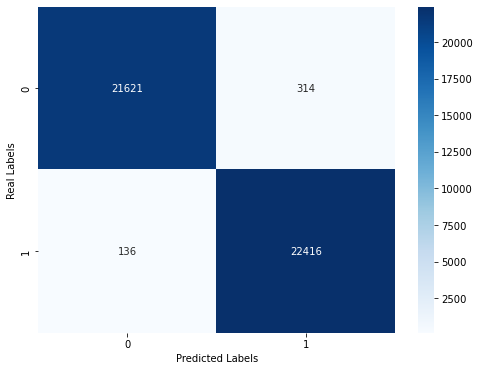

In [34]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(df_Reuters_y, Reuters_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

### Buzzfeed

In [35]:
# Create a list of preprocessed articles
Buzzfeed_X = []
for article_train in df_Buzzfeed_x[:]:
    Buzzfeed_X.append(preprocess_text(article_train))

df_Buzzfeed_x = Buzzfeed_X

In [36]:
# Create y_pred_Reuters
Buzzfeed_test_matrix = vectorizer.transform(df_Buzzfeed_x)
Buzzfeed_y_pred = svm.predict(Buzzfeed_test_matrix)

In [42]:
pd.DataFrame(classification_report(df_Buzzfeed_y, Buzzfeed_y_pred, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,45.0,56.0,1.0,101.0,101.0


Text(51.0, 0.5, 'Real Labels')

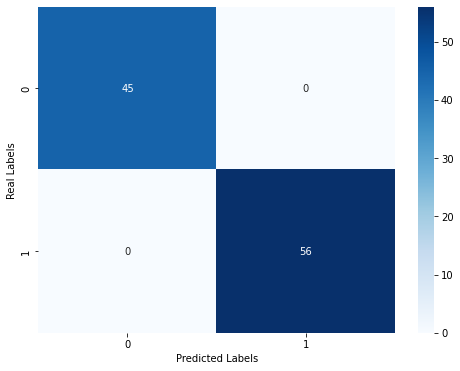

In [38]:
# plot the confusion matrix
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(df_Buzzfeed_y, Buzzfeed_y_pred), annot=True, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')